<a href="https://colab.research.google.com/github/lnalice/FIFA-fee-forcasting/blob/master/FIFA_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint

# setting package
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# standard data
from sklearn.preprocessing import StandardScaler

# model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_validate

# LGBM
from lightgbm import LGBMRegressor

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

#
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.model_selection import KFold
# from sklearn.tree import plot_tree


# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [4]:
FIFA_files = files.upload();

train_df = pd.read_csv('/content/FIFA_train.csv')
test_df = pd.read_csv('/content/FIFA_test.csv')
submission = pd.read_csv('/content/submission.csv')

Saving FIFA_test.csv to FIFA_test.csv
Saving FIFA_train.csv to FIFA_train.csv
Saving submission.csv to submission.csv


# Data Preprocessing

## 기존 데이터 확인

In [5]:
print("\n--------------------- uniqueIndex ---------------------")
id = train_df['id'].unique();
name = train_df['name'].unique();
age = train_df['age'].unique();
continent = train_df['continent'].unique();
contract_until = train_df['contract_until'].unique();
position = train_df['position'].unique();
prefer_foot = train_df['prefer_foot'].unique();
reputation = train_df['reputation'].unique();
stat_overall = train_df['stat_overall'].unique();
stat_potential = train_df['stat_potential'].unique();
stat_skill_moves = train_df['stat_skill_moves'].unique();
value = train_df['value'].unique();

uniqueIndex = {
    "id" : id,
    "name" : name,
    "age" : age,
  "continent" : continent,
  "contract_until" :contract_until,
  "position" : position,
  "prefer_foot" : prefer_foot,
  "reputation" : reputation,
  "stat_overall" : stat_overall,
  "stat_potential" : stat_potential,
  "stat_skill_moves" : stat_skill_moves,
  "value" : value
}

uniqueIndex


--------------------- uniqueIndex ---------------------


{'id': array([    0,     3,     7, ..., 16941, 16942, 16948]),
 'name': array(['L. Messi', 'De Gea', 'L. Suárez', ..., 'N. Fuentes', 'J. Milli',
        'N. Christoffersson'], dtype=object),
 'age': array([31, 27, 32, 25, 26, 29, 33, 30, 40, 24, 28, 34, 23, 22, 35, 36, 21,
        18, 19, 37, 20, 39, 17, 38, 16]),
 'continent': array(['south america', 'europe', 'africa', 'asia', 'oceania'],
       dtype=object),
 'contract_until': array(['2021', '2020', '2019', '2023', '2022', '2024', 'Jun 30, 2019',
        '2026', 'Dec 31, 2018', '2018', '2025', 'Jun 30, 2020',
        'May 31, 2020', 'May 31, 2019', 'Jan 31, 2019', 'Jan 1, 2019',
        'Jan 12, 2019'], dtype=object),
 'position': array(['ST', 'GK', 'DF', 'MF'], dtype=object),
 'prefer_foot': array(['left', 'right'], dtype=object),
 'reputation': array([5., 4., 3., 1., 2.]),
 'stat_overall': array([94, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76,
        75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61,

## 데이터 전처리 시작

### train_df → new_train_df → tidy_train_df
- new_train_df : 데이터 형식 변환
- tidy_train_df : 왜도 높은 칼럼 로그변환, 더미화, id/name 열 삭제


## (1) new_train_df
### value 수정 (형식변환, 의미변환)
- contract_until
  - 수정 전 : string 타입, 형식 다름
  - 수정 후 : int 타입, 형식 맞추기(ex 2019)
  - 완   료 : 계약 기간(ex 2024-2018= 6)

- value
  - 수정 전 : 값 그대로
  - 수정 후 : log(value)

<!-- get_dummies : 범주형 칼럼 더미화해서 표준화함 -->
<!-- np.logp1 : 왜도가 높은 컬럼 로그 변환 -->


In [6]:
'''
contract_until
'''
oldDate = []
newDate = []
for e in train_df["contract_until"] :
    oldDate.append(e)
    newDate.append(int(e[-4:])-2018)

new_train_df = train_df.replace(oldDate, newDate)
uniqueIndex["contract_until"] = new_train_df["contract_until"].unique()

'''
value
'''
oldValue = []
newValue= []
for e in train_df["value"] :
    oldValue.append(e)
    newValue.append(np.log1p(e))

new_train_df = new_train_df.replace(oldValue, newValue)
uniqueIndex["value"] = new_train_df["value"].unique()

print("\n--------------------- new_train_df ---------------------")
print(new_train_df)


--------------------- new_train_df ---------------------
           id                name  age      continent  contract_until  \
0         0.0            L. Messi   31  south america               3   
1         3.0              De Gea   27         europe               2   
2         7.0           L. Suárez   31  south america               3   
3         8.0        Sergio Ramos   32         europe               2   
4         9.0            J. Oblak   25         europe               3   
...       ...                 ...  ...            ...             ...   
8927  16925.0          S. Adewusi   18         africa               1   
8928  16936.0           C. Ehlich   19         europe               2   
8929  16941.0          N. Fuentes   18  south america               3   
8930  16942.0            J. Milli   18         europe               3   
8931  16948.0  N. Christoffersson   19         europe               2   

     position prefer_foot  reputation  stat_overall  stat_potenti

## (2) tidy_train_df

### 왜도가 높은 컬럼 로그 변환
- name : 열 삭제
- reputation : 로그 변환
  - (1) 0이나 0에 매우 가까운 값이 없다.
  - (2) 음수가 없다
  - 즉, 로그 변환 가능하며, 왜도가 크기 때문에 로그 변환을 함

### 범주형 칼럼 더미화
- continent, position, prefer_foot 더미화
- id : 열 삭제


--------------------- tidy_train_df (drop) ---------------------
    id  age  contract_until  reputation  stat_overall  stat_potential  \
0  0.0   31               3         5.0            94              94   
1  3.0   27               2         4.0            91              93   
2  7.0   31               3         5.0            91              91   
3  8.0   32               2         4.0            91              91   
4  9.0   25               3         3.0            90              93   

   stat_skill_moves      value  
0               4.0  18.520526  
1               1.0  18.092177  
2               3.0  18.197537  
3               3.0  17.747336  
4               1.0  18.035018  

--------------------- skew ---------------------
id                  0.131275
age                 0.356824
contract_until      0.493837
reputation          3.774495
stat_overall        0.026723
stat_potential      0.285905
stat_skill_moves    0.086536
value               0.308798
dtype: float64


,age,contract_until,reputation,stat_overall,stat_potential,stat_skill_moves,cnt_africa,cnt_asia,cnt_europe,cnt_oceania,cnt_south america,pos_DF,pos_GK,pos_MF,pos_ST,foot_left,foot_right,value
0,31,3,1.609438,94,94,4.0,0,0,0,0,1,0,0,0,1,1,0,18.520526
1,27,2,1.386294,91,93,1.0,0,0,1,0,0,0,1,0,0,0,1,18.092177
2,31,3,1.609438,91,91,3.0,0,0,0,0,1,0,0,0,1,0,1,18.197537
3,32,2,1.386294,91,91,3.0,0,0,1,0,0,1,0,0,0,0,1,17.747336
4,25,3,1.098612,90,93,1.0,0,0,1,0,0,0,1,0,0,0,1,18.035018


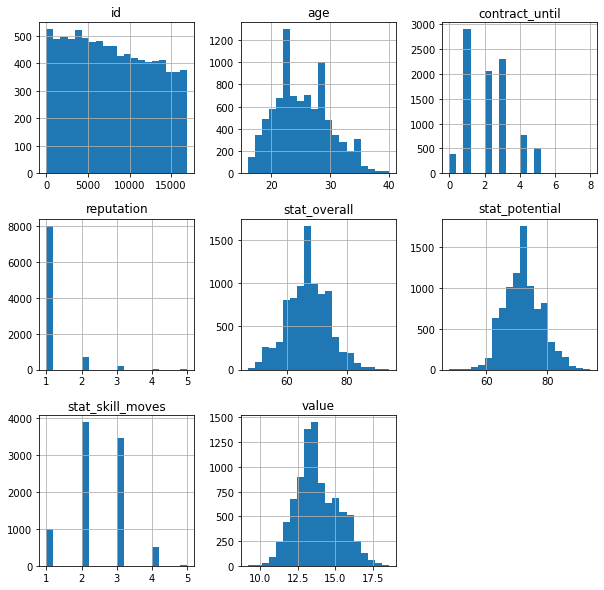

In [7]:
'''
이름과 더미화할 데이터 드롭
'''
print("\n--------------------- tidy_train_df (drop) ---------------------")
tidy_train_df = new_train_df.drop(columns =['name', 'continent', 'position', 'prefer_foot'])
print(tidy_train_df.head())

'''
왜도확인
'''
print("\n--------------------- skew ---------------------")
print(tidy_train_df.skew())
tidy_train_df.hist(bins=20, figsize=(10,10))


'''
reputation - 로그 변환
(1) 0이나 0에 매우 가까운 값이 없다.
(2) 음수가 없다
즉, 로그 변환 가능하다
'''
print("\n--------------------- tidy_train_df (log) ---------------------")
tidy_train_df['reputation'] = np.log(tidy_train_df['reputation'])
print(tidy_train_df.head())



'''
더미화 - continent, position, prefer_foot
'''
print("\n--------------------- tidy_train_df (dummies) ---------------------")
id = tidy_train_df['id']
dummies_continent = pd.get_dummies(new_train_df['continent'], prefix='cnt', dummy_na=False)
dummies_position = pd.get_dummies(new_train_df['position'], prefix='pos', dummy_na=False)
dummies_prefer_foot = pd.get_dummies(new_train_df['prefer_foot'], prefix='foot', dummy_na=False)
dummies_df = pd.concat([id, dummies_continent,dummies_position, dummies_prefer_foot], axis=1)
dummies_df.head()

'''
merge
'''
tidy_train_df = pd.merge(tidy_train_df,dummies_df,  how='left')
tidy_train_df.columns

'''
순서 바꾸기 & drop id
'''
before_value = tidy_train_df.columns[1:7].to_list()
after_value = dummies_df.columns[1:].to_list()
new_col = before_value + after_value + ['value']
tidy_train_df=tidy_train_df[new_col]
tidy_train_df.head()

In [62]:
tidy_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8932 entries, 0 to 8931
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                8932 non-null   int64  
 1   contract_until     8932 non-null   int64  
 2   reputation         8932 non-null   float64
 3   stat_overall       8932 non-null   int64  
 4   stat_potential     8932 non-null   int64  
 5   stat_skill_moves   8932 non-null   float64
 6   cnt_africa         8932 non-null   uint8  
 7   cnt_asia           8932 non-null   uint8  
 8   cnt_europe         8932 non-null   uint8  
 9   cnt_oceania        8932 non-null   uint8  
 10  cnt_south america  8932 non-null   uint8  
 11  pos_DF             8932 non-null   uint8  
 12  pos_GK             8932 non-null   uint8  
 13  pos_MF             8932 non-null   uint8  
 14  pos_ST             8932 non-null   uint8  
 15  foot_left          8932 non-null   uint8  
 16  foot_right         8932 

# Machine Learning


##  Train data
### train_input
- id, age를 제외한 모든 열
- StandardScaler()

### train_taget
- value 열 

In [9]:
print("\n--------------------- train_input ---------------------")
train_input= tidy_train_df.drop(columns =['value'])
ss = StandardScaler()
train_input = ss.fit_transform(train_input)
print(train_input)

print("\n--------------------- train_target ---------------------")
train_target = new_train_df.iloc[:,-1]
print(train_target)


--------------------- train_input ---------------------
[[ 1.2493085   0.63595162  6.08585496 ...  2.05881269  1.80651169
  -1.80651169]
 [ 0.38635718 -0.15342023  5.19671935 ... -0.48571684 -0.55355302
   0.55355302]
 [ 1.2493085   0.63595162  6.08585496 ...  2.05881269 -0.55355302
   0.55355302]
 ...
 [-1.5552833   0.63595162 -0.32709558 ... -0.48571684 -0.55355302
   0.55355302]
 [-1.5552833   0.63595162 -0.32709558 ... -0.48571684 -0.55355302
   0.55355302]
 [-1.33954546 -0.15342023 -0.32709558 ...  2.05881269 -0.55355302
   0.55355302]]

--------------------- train_target ---------------------
0       18.520526
1       18.092177
2       18.197537
3       17.747336
4       18.035018
          ...    
8927    11.002117
8928    10.596660
8929    10.819798
8930    10.819798
8931    11.002117
Name: value, Length: 8932, dtype: float64


## Test data

In [10]:
test_df.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves
0,1,Cristiano Ronaldo,33,europe,2022,ST,right,5.0,94,94,5.0
1,2,Neymar Jr,26,south america,2022,ST,right,5.0,92,93,5.0
2,4,K. De Bruyne,27,europe,2023,MF,right,4.0,91,92,4.0
3,5,E. Hazard,27,europe,2020,ST,right,4.0,91,91,4.0
4,6,L. Modrić,32,europe,2020,MF,right,4.0,91,91,4.0



--------------------- tidy_test_df (drop) ---------------------
   id  age  contract_until  reputation  stat_overall  stat_potential  \
0   1   33               4         5.0            94              94   
1   2   26               4         5.0            92              93   
2   4   27               5         4.0            91              92   
3   5   27               2         4.0            91              91   
4   6   32               2         4.0            91              91   

   stat_skill_moves  
0               5.0  
1               5.0  
2               4.0  
3               4.0  
4               4.0  

--------------------- skew ---------------------
id                  0.118753
age                 0.364907
contract_until      0.476073
reputation          3.644128
stat_overall        0.134543
stat_potential      0.324914
stat_skill_moves    0.134095
dtype: float64

--------------------- tidy_test_df (log) ---------------------
   id  age  contract_until  reputation

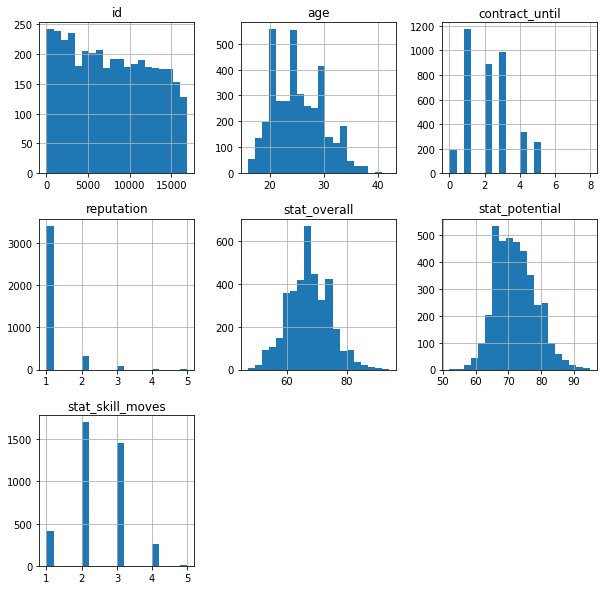

In [83]:
'''
contract_until
'''
oldDate = []
newDate = []
for e in test_df["contract_until"] :
    oldDate.append(e)
    newDate.append(int(e[-4:])-2018)

new_test_df = test_df.replace(oldDate, newDate)
uniqueIndex["contract_until"] = new_test_df["contract_until"].unique()

'''
이름과 더미화할 데이터 드롭
'''
print("\n--------------------- tidy_test_df (drop) ---------------------")
tidy_test_df = new_test_df.drop(columns =['name', 
                    'continent', 'position', 'prefer_foot'])
print(tidy_test_df.head())

'''
왜도확인
'''
print("\n--------------------- skew ---------------------")
print(tidy_test_df.skew())
tidy_test_df.hist(bins=20, figsize=(10,10))


'''
reputation - 로그 변환
(1) 0이나 0에 매우 가까운 값이 없다.
(2) 음수가 없다
즉, 로그 변환 가능하다
'''
print("\n--------------------- tidy_test_df (log) ---------------------")
tidy_test_df['reputation'] = np.log(tidy_test_df['reputation'])
print(tidy_test_df.head())



'''
더미화 - continent, position, prefer_foot
'''
print("\n--------------------- tidy_test_df (dummies) ---------------------")
id = tidy_test_df['id']
dummies_continent = pd.get_dummies(new_test_df['continent'], prefix='cnt', dummy_na=False)
dummies_position = pd.get_dummies(new_test_df['position'], prefix='pos', dummy_na=False)
dummies_prefer_foot = pd.get_dummies(new_test_df['prefer_foot'], prefix='foot', dummy_na=False)
dummies_df = pd.concat([id, dummies_continent,dummies_position, dummies_prefer_foot], axis=1)
print(dummies_df.head())

'''
merge
'''
tidy_test_df = pd.merge(tidy_test_df,dummies_df,  how='left')
tidy_test_df.columns

'''
순서 바꾸기 & drop id
'''
before_value = tidy_test_df.columns[1:7].to_list()
after_value = dummies_df.columns[1:].to_list()
new_col = before_value + after_value
tidy_test_df=tidy_test_df[new_col]
tidy_test_df.head()

print("\n--------------------- tidy_test_df (completed) ---------------------")
print(tidy_test_df.head())
print(tidy_test_df.info())


'''
test_input
'''
print("\n--------------------- test_input ---------------------")
ss = StandardScaler()
test_input = ss.fit_transform(tidy_test_df)
print(test_input)

## LGBM
- Random Search
  - 연속적인 매개변수의 최적값 찾을 때 유용
  - 과적합 막기 위해 최적의 파라미터 값 찾기

In [136]:
'''
LGBM
'''
lgbm = LGBMRegressor()

'''
Random Search
'''
eval_set = [(train_input, train_target)]
eval_metric = 'rmse'

params = {
    'num_leaves': randint(31,50),
    'min_child_samples': randint(10,30),
	 'bagging_fraction' : uniform(0.5,0.1),
	 'feature_fraction' : uniform(0.5,0.1),
	 'learning_rate' : uniform(0.01, 0.1),
	 'early_stopping_round' : randint(5,10),
}

rs = RandomizedSearchCV(
    estimator=lgbm, param_distributions=params, n_iter=100, cv=5, n_jobs=-1, 
    scoring='neg_mean_squared_error', random_state=42, verbose=1)
rs.fit(train_input, train_target, eval_set = eval_set, eval_metric = eval_metric)

print("best_params_ : ", rs.best_params_)
print("train_score  : ", rs.score(train_input, train_target))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] feature_fraction is set=0.561500722669917, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.561500722669917
[LightGBM] [Warning] bagging_fraction is set=0.5070416130849544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5070416130849544
[1]	training's rmse: 1.26308	training's l2: 1.59537
[2]	training's rmse: 1.14109	training's l2: 1.30208
[3]	training's rmse: 1.02652	training's l2: 1.05375
[4]	training's rmse: 0.919737	training's l2: 0.845915
[5]	training's rmse: 0.847596	training's l2: 0.718419
[6]	training's rmse: 0.765173	training's l2: 0.585489
[7]	training's rmse: 0.691446	training's l2: 0.478097
[8]	training's rmse: 0.626384	training's l2: 0.392357
[9]	training's rmse: 0.571766	training's l2: 0.326916
[10]	training's rmse: 0.521344	training's l2: 0.2718
[11]	training's rmse: 0.468771	training's l2: 0.219746
[12]	training's rmse: 0.440427	training's l2: 0.19

In [137]:
train_pred = rs.predict(train_input)
train_rmse = mean_squared_error(train_target, train_pred, squared=False)

print("train RMSE : ", train_rmse)

train RMSE :  0.0618614988807825


## Model evaluation

In [138]:
print("\n--------------------- lgbm with random search ---------------------")

'''
lgbm_best : set best_params_
'''
# categorical_col_name = ['cnt_africa', 'cnt_asia', 'cnt_europe', 'cnt_oceania', 'cnt_south america', 'pos_DF', 'pos_GK', 'pos_MF', 'pos_ST', 'foot_left', 'foot_right']
categorical_col_num = [6,7,8,9,10,11,12,13,14,15,16]
bp_rs = rs.best_params_

lgbm_best = LGBMRegressor(num_leaves= bp_rs['num_leaves'], min_child_samples= bp_rs['min_child_samples'],
                     bagging_fraction=bp_rs['bagging_fraction'], feature_fraction = bp_rs['feature_fraction'], 
                     early_stopping_round= bp_rs['early_stopping_round'], learning_rate= bp_rs['learning_rate'],
                     categorical_feature= categorical_col_num)

'''
validate

'''
input_train, input_val, target_train, target_val = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

eval_set = [(input_val, target_val)]

lgbm_best.fit(input_train, target_train, eval_set=eval_set, early_stopping_rounds=5, verbose=False)

scores = lgbm_best.score(input_val, target_val)
pred = lgbm_best.predict(input_val)

print('SCORE                         : ', scores)
print('MSE(mean squeared error)      : ', mean_squared_error(target_val, pred))
print('RMSE(root mean squared error) : ', np.sqrt(mean_squared_error(target_val, pred)))
print('MAE(mean absolute error)      : ', mean_absolute_error(target_val, pred))


--------------------- lgbm with random search ---------------------
[LightGBM] [Warning] feature_fraction is set=0.561500722669917, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.561500722669917
[LightGBM] [Warning] bagging_fraction is set=0.5070416130849544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5070416130849544
SCORE                         :  0.9971728361572244
MSE(mean squeared error)      :  0.00605101542884672
RMSE(root mean squared error) :  0.07778827308050179
MAE(mean absolute error)      :  0.05230536377707307


## Submission
- predict value with test_input
- convert to submission.csv

In [139]:
'''
predict
'''
predict_tmp_data = lgbm_best.predict(test_input)

'''
replace value 
'''
predict_data= []
for e in predict_tmp_data :
    predict_data.append(np.expm1(e))

'''
array to datagram
'''
submission = pd.DataFrame()
submission['id'] = new_test_df['id']
submission['value'] = predict_data
submission.to_csv('submission.csv', index = False)

print(submission)

         id         value
0         1  3.527839e+07
1         2  7.633133e+07
2         4  7.443450e+07
3         5  6.837572e+07
4         6  5.360389e+07
...     ...           ...
3823  16924  5.546033e+04
3824  16929  4.842492e+04
3825  16932  5.603228e+04
3826  16937  5.027882e+04
3827  16943  4.879204e+04

[3828 rows x 2 columns]
